# Convolutional Neural Networks

<a href="https://colab.research.google.com/github/chattopadhyayA/ml_pursue2025/blob/master/content/08_CNN.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

```{figure} images/2D_Convolution_Animation.gif
---
height: 300px
name:   2D_Convolution_Animation
align:  center
---
"Image source: https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif"
```

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set manual seed for reproducibility
torch.manual_seed(0)

# -----------------------------
# 1. Load the MNIST Dataset
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:08<00:00, 1.16MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 682kB/s]
100%|██████████| 1.65M/1.65M [00:18<00:00, 90.3kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 126kB/s]


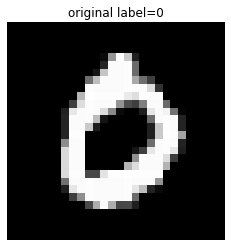

In [17]:
# Show a single image
def show_image(img, title=""):
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

test_image, test_label = test_set[3]
show_image(test_image, title="original label={}".format(test_label))


In [18]:
# -----------------------------
# 2. Define the Simple CNN Model
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)  # 28x28 -> 26x26
        self.pool1 = nn.MaxPool2d(2, 2)  # 26x26 -> 13x13

        self.conv2 = nn.Conv2d(4, 8, 3)  # 13x13 -> 11x11
        self.pool2 = nn.MaxPool2d(2, 2)  # 11x11 -> 5x5

        self.fc = nn.Linear(8 * 5 * 5, 10)  # final output layer

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))  # -> [4, 13, 13]
        x = self.pool2(torch.relu(self.conv2(x)))  # -> [8, 5, 5]
        x = x.view(-1, 8 * 5 * 5)  # flatten
        x = self.fc(x)  # final logits
        return x


In [19]:
# -----------------------------
# 3. Training the CNN
# -----------------------------
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training the CNN...")
for epoch in range(10):  # few epochs for demonstration
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.3f}")


Training the CNN...
Epoch 1 - Loss: 436.432
Epoch 2 - Loss: 128.635
Epoch 3 - Loss: 97.437
Epoch 4 - Loss: 85.580
Epoch 5 - Loss: 78.195
Epoch 6 - Loss: 72.594
Epoch 7 - Loss: 68.360
Epoch 8 - Loss: 65.340
Epoch 9 - Loss: 62.714
Epoch 10 - Loss: 60.999


In [20]:

# -----------------------------
# 4. Testing + Visualizing One Sample
# -----------------------------
# Get one test image
test_image, test_label = test_set[0]
input_image = test_image.unsqueeze(0)  # add batch dim: [1, 1, 28, 28]

# Run through model
model.eval()
with torch.no_grad():
    x1 = torch.relu(model.conv1(input_image))
    x2 = model.pool1(x1)

    x3 = torch.relu(model.conv2(x2))
    x4 = model.pool2(x3)

    flat = x4.view(-1, 8 * 5 * 5)
    logits = model.fc(flat)
    probs = torch.softmax(logits, dim=1)
    prediction = probs.argmax(dim=1).item()


True Label: 7 | Predicted: 7


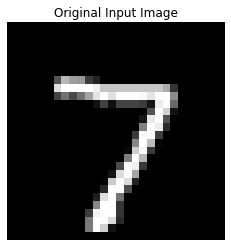

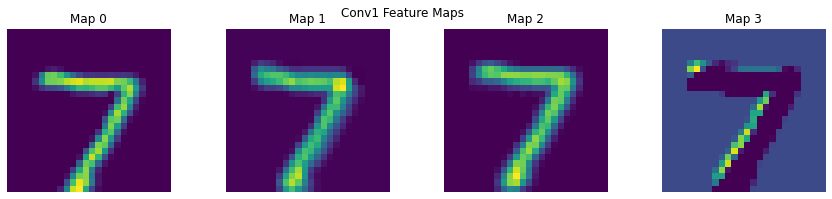

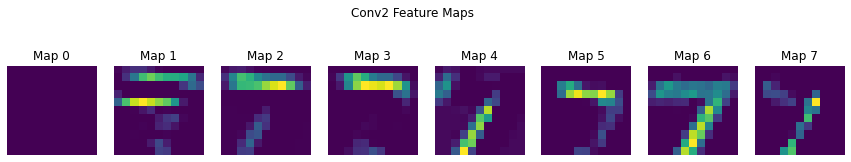

In [21]:

# -----------------------------
# 5. Show Original Image
# -----------------------------
print(f"True Label: {test_label} | Predicted: {prediction}")
show_image(test_image, title="Original Input Image")

# -----------------------------
# 6. Visualize Feature Maps (Conv Layers)
# -----------------------------
def show_feature_maps(tensor, title=""):
    tensor = tensor.squeeze()
    num_maps = tensor.shape[0]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))
    for i in range(num_maps):
        axes[i].imshow(tensor[i], cmap='viridis')
        axes[i].set_title(f"Map {i}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

show_feature_maps(x1, "Conv1 Feature Maps")
show_feature_maps(x3, "Conv2 Feature Maps")


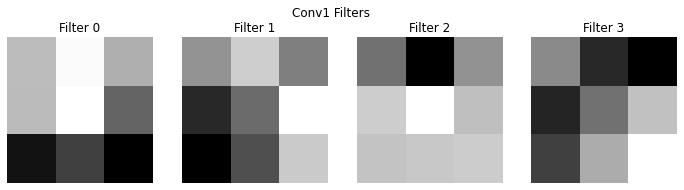

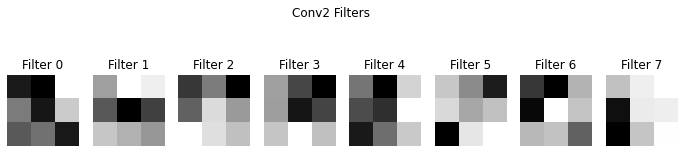

In [22]:

# -----------------------------
# 7. Visualize Filters (Conv Weights)
# -----------------------------
def show_conv_filters(conv_layer, title=""):
    weights = conv_layer.weight.data.clone()
    num_filters = weights.shape[0]
    fig, axes = plt.subplots(1, num_filters, figsize=(12, 3))
    for i in range(num_filters):
        axes[i].imshow(weights[i, 0], cmap='gray')
        axes[i].set_title(f"Filter {i}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

show_conv_filters(model.conv1, "Conv1 Filters")
show_conv_filters(model.conv2, "Conv2 Filters")
